### **Summary**
Validation Accuracy: 84% <br>
Test Accuracy: 77%<br>



**Problem Statement**

#### **Classification of Top and Bottom Level organisation**
The dataset consists of description and Text from various scraped websites of organizations.

Number of Top Organizations: 1500
Number of Bottom Organizations: 1500

Number of Attributes/Columns in data: 13

#### **Attribute Information**:


*   city :  Location  
*   country: Location of country
*   description: Description of the organization
*   h1, h2, h3, h4, h5, h6, : Various header text
*   meta: Meta text
*   text: Summary text
*   hash: Hash code
*   title: Title of organization


Create a probabilistic model to predict the level of organization Top or Bottom based on description column using different ML classification algorithms.


# Importing Libraries

In [0]:
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
import itertools, string, operator, re, unicodedata, nltk
from operator import itemgetter
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import TweetTokenizer, RegexpTokenizer
from bs4 import BeautifulSoup
import numpy as np
from itertools import combinations
from gensim.models import Phrases
from collections import Counter

#Contraction map
c_dict = {
  "ain't": "am not",
  "aren't": "are not",
  "can't": "cannot",
  "can't've": "cannot have",
  "'cause": "because",
  "could've": "could have",
  "couldn't": "could not",
  "couldn't've": "could not have",
  "didn't": "did not",
  "doesn't": "does not",
  "don't": "do not",
  "don’t": "do not",   
  "hadn't": "had not",
  "hadn't've": "had not have",
  "hasn't": "has not",
  "haven't": "have not",
  "he'd": "he would",
  "he'd've": "he would have",
  "he'll": "he will",
  "he'll've": "he will have",
  "he's": "he is",
  "how'd": "how did",
  "how'd'y": "how do you",
  "how'll": "how will",
  "how's": "how is",
  "i'd": "I would",
  "i'd've": "I would have",
  "i'll": "I will",
  "i'll've": "I will have",
  "i'm": "I am",
  "i've": "I have",
  "isn't": "is not",
  "it'd": "it had",
  "it'd've": "it would have",
  "it'll": "it will",
  "it'll've": "it will have",
  "it's": "it is",
  "let's": "let us",
  "ma'am": "madam",
  "mayn't": "may not",
  "might've": "might have",
  "mightn't": "might not",
  "mightn't've": "might not have",
  "must've": "must have",
  "mustn't": "must not",
  "mustn't've": "must not have",
  "needn't": "need not",
  "needn't've": "need not have",
  "o'clock": "of the clock",
  "oughtn't": "ought not",
  "oughtn't've": "ought not have",
  "shan't": "shall not",
  "sha'n't": "shall not",
  "shan't've": "shall not have",
  "she'd": "she would",
  "she'd've": "she would have",
  "she'll": "she will",
  "she'll've": "she will have",
  "she's": "she is",
  "should've": "should have",
  "shouldn't": "should not",
  "shouldn't've": "should not have",
  "so've": "so have",
  "so's": "so is",
  "that'd": "that would",
  "that'd've": "that would have",
  "that's": "that is",
  "there'd": "there had",
  "there'd've": "there would have",
  "there's": "there is",
  "they'd": "they would",
  "they'd've": "they would have",
  "they'll": "they will",
  "they'll've": "they will have",
  "they're": "they are",
  "they've": "they have",
  "to've": "to have",
  "wasn't": "was not",
  "we'd": "we had",
  "we'd've": "we would have",
  "we'll": "we will",
  "we'll've": "we will have",
  "we're": "we are",
  "we've": "we have",
  "we’ve": "we have",
  "weren't": "were not",
  "what'll": "what will",
  "what'll've": "what will have",
  "what're": "what are",
  "what's": "what is",
  "what've": "what have",
  "when's": "when is",
  "when've": "when have",
  "where'd": "where did",
  "where's": "where is",
  "where've": "where have",
  "who'll": "who will",
  "who'll've": "who will have",
  "who's": "who is",
  "who've": "who have",
  "why's": "why is",
  "why've": "why have",
  "will've": "will have",
  "won't": "will not",
  "won't've": "will not have",
  "would've": "would have",
  "wouldn't": "would not",
  "wouldn't've": "would not have",
  "y'all": "you all",
  "y'alls": "you alls",
  "y'all'd": "you all would",
  "y'all'd've": "you all would have",
  "y'all're": "you all are",
  "y'all've": "you all have",
  "you'd": "you had",
  "you'd've": "you would have",
  "you'll": "you you will",
  "you'll've": "you you will have",
  "you're": "you are",
  "you've": "you have"
}

c_re = re.compile('(%s)' % '|'.join(c_dict.keys()))

add_stop = ['', ' ', 'say', 's', 'u', 'ap', 'afp', '...', 'n', '\\']

stop_words = ENGLISH_STOP_WORDS.union(add_stop)

tokenizer = TweetTokenizer()
pattern = r"(?u)\b\w\w+\b" 

lemmatizer = WordNetLemmatizer()

punc = list(set(string.punctuation))

def casual_tokenizer(text): #Splits words on white spaces (leaves contractions intact) and splits out trailing punctuation
    tokens = tokenizer.tokenize(text)
    return tokens

#Function to replace the nltk pos tags with the corresponding wordnet pos tag to use the wordnet lemmatizer
def get_word_net_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return None
    
def lemma_wordnet(tagged_text):
    final = []
    for word, tag in tagged_text:
        wordnet_tag = get_word_net_pos(tag)
        if wordnet_tag is None:
            final.append(lemmatizer.lemmatize(word))
        else:
            final.append(lemmatizer.lemmatize(word, pos=wordnet_tag))
    return final

def expandContractions(text, c_re=c_re):
    def replace(match):
        return c_dict[match.group(0)]
    return c_re.sub(replace, text)

def remove_html(text):
    soup = BeautifulSoup(text, "html5lib")
    tags_del = soup.get_text()
    uni = unicodedata.normalize("NFKD", tags_del)
    bracket_del = re.sub(r'\[.*?\]', '  ', uni)
    apostrphe = re.sub('’',"’", "'","•","®","`", bracket_del)
    string = apostrphe.replace('\r','  ')
    string = string.replace('\n','  ')
    extra_space = re.sub(' +',' ', string)
    return extra_space

def process_text(text):
    soup = BeautifulSoup(text, "lxml")
    tags_del = soup.get_text()
    no_html = re.sub('<[^>]*> ’', '', tags_del)
    tokenized = casual_tokenizer(no_html)
    lower = [item.lower() for item in tokenized]
    decontract = [expandContractions(item, c_re=c_re) for item in lower]
    tagged = nltk.pos_tag(decontract)
    lemma = lemma_wordnet(tagged)
    no_num = [re.sub('[^A-Za-z0-9]+', '', each) for each in lemma]
    no_punc = [w for w in no_num if w not in punc]
    no_stop = [w for w in no_punc if w not in stop_words]
    return no_stop

def word_count(text):
    return len(str(text).split(' '))

def word_freq(clean_text_list, top_n):
    """
    Word Frequency
    """
    flat = [item for sublist in clean_text_list for item in sublist]
    with_counts = Counter(flat)
    top = with_counts.most_common(top_n)
    word = [each[0] for each in top]
    num = [each[1] for each in top]
    return pd.DataFrame([word, num]).T

def word_freq_bigrams(clean_text_list, top_n):
    """
    Word Frequency With Bigrams
    """
    bigram_model = Phrases(clean_text_list, min_count=2, threshold=1)
    w_bigrams = list(bigram_model[clean_text_list])
    flat_w_bigrams = [item for sublist in w_bigrams for item in sublist]
    with_counts = Counter(flat_w_bigrams)
    top = with_counts.most_common(top_n)
    word = [each[0] for each in top]
    num = [each[1] for each in top]
    return pd.DataFrame([word, num]).T


def bigram_freq(clean_text_list, top_n):
    bigram_model = Phrases(clean_text_list, min_count=2, threshold=1)
    w_bigrams = list(bigram_model[clean_text_list])
    flat_w_bigrams = [item for sublist in w_bigrams for item in sublist]
    bigrams = []
    for each in flat_w_bigrams:
        if '_' in each:
            bigrams.append(each)
    counts = Counter(bigrams)
    top = counts.most_common(top_n)
    word = [each[0] for each in top]
    num = [each[1] for each in top]
    return pd.DataFrame([word, num]).T

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_extraction.stop_words module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_extraction.text. Anything that cannot be imported from sklearn.feature_extraction.text is now part of the private API.
  warnings.warn(message, FutureWarning)


In [0]:
import nltk
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
  

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [0]:
import pandas as pd
import numpy as np
import json

'''Features'''
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import label_binarize

'''Classifiers'''
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

'''Metrics/Evaluation'''
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix
from scipy import interp
from itertools import cycle

'''Plotting'''
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

'''Display'''
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
import warnings
warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:,.2f}'.format

# Reading Data

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# Exploratory Data Analysis

## [2] Data Cleaning: 

Removing the NA values and dropping unwanted columns.
Adding a 'Category : 0 for Bottom and 1 for Top

In [0]:
df = pd.read_csv("/content/drive/My Drive/Startus_project/result_top_1500_cleaned.csv")
df_1= pd.read_csv("/content/drive/My Drive/Startus_project/result_bottom_1500_cleaned.csv")
df.drop(['hash','city','country'], inplace=True,axis=1)
df_1.drop(['hash','city','country'], inplace=True,axis=1)
df_1['Category']= 0
df['Category']= 1
df2=df.append(df_1, ignore_index=True)
df2.dropna(axis=0,subset=['description'])

,description,h1,h2,h3,h4,h5,h6,meta,text,title,Category
0,"(PARTNERS, TRUSTEES, DIRECTORS, ADVISORS or EX...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,"As of January 1, 2014 the Internet Corporation...",Domain Pending Verification,1
1,Welcome to the official DXC Technology LinkedI...,About DXC Technology\nAnalytic Services Case S...,5 trends to watch in 2020\nA NEW LEVEL OF CARE...,Additional DXC ServiceNow Resources\nApril 201...,DXC Technology: Global IT Services and Solutio...,DXC Technology: Global IT Services and Solutio...,About Our Partnership\nAbout ServiceNow\nDXC T...,DXC Technology: Global IT Services and Solutio...,"""Accessible and aggregated data across the car...",DXC Technology: Global IT Services and Solutio...,1
2,"On September 1, 2018 Bon Secours Health System...",Bon Secours Mercy Health | Stronger Together\n...,A heritage rooted in the healing ministry of J...,Board of Directors\nBon Secours Mercy Health L...,Bon Secours Mercy Health | Stronger Together\n...,Bon Secours Mercy Health | Stronger Together\n...,Bon Secours Mercy Health | Stronger Together\n...,Bon Secours Mercy Health | Stronger Together,$\n.\n0\n01\n06\n1\n15\n1500000\n2\n20\n28\n3\...,Bon Secours Mercy Health | Stronger Together,1
3,Thales Portugal is a Competence Centre of the ...,Australia | Thales Group\nContact us | Thales ...,Activities\nAustralia | Thales Group\nContact ...,Australia | Thales Group\nContact us | Thales ...,Australia | Thales Group\nAutonomous Systems\n...,Australia | Thales Group\nContact\nContact us\...,Australia | Thales Group\nContact us | Thales ...,"For more than 40 years now, Thales Alenia Spac...","#1\n$A1.6\n(33%), Thales Alenia Space also tea...",Space | Thales Group,1
4,"Collins Aerospace, a unit of United Technologi...",About Us\nCollins Aerospace\nCollins Aerospace...,About Us\nCollins Aerospace\nCollins Aerospace...,About Us\nCollins Aerospace\nCollins Aerospace...,About Us\nCollins Aerospace\nCollins Aerospace...,About Us\nCollins Aerospace\nCollins Aerospace...,About Us\nCollins Aerospace\nCollins Aerospace...,Collins Aerospace,$151.86\n$152.05\n$23 Billion\n$3.1 Billion\n*...,Collins Aerospace,1
...,...,...,...,...,...,...,...,...,...,...,...
2995,Does your company have HR questions that you c...,HR Consultancy Services & HR Outsourcing Compa...,HR Consultancy Services & HR Outsourcing Compa...,HR Consultancy Services & HR Outsourcing Compa...,HR Consultancy Services & HR Outsourcing Compa...,HR Consultancy Services & HR Outsourcing Compa...,HR Consultancy Services & HR Outsourcing Compa...,HR Consultancy Services & HR Outsourcing Compa...,ABOUT HR ALLIANCE\nAbout\nAbout Us\nAdvice\nAs...,HR Consultancy Services & HR Outsourcing Compa...,0
2996,dot.LA’s mission is to celebrate and empower t...,about - dot.LA\ndot.LA,about - dot.LA\ndot.LA,about - dot.LA\ndot.LA,about - dot.LA\ndot.LA,about - dot.LA\ndot.LA,about - dot.LA\ndot.LA,dot.LA,'I Tricked You All': Paris Hilton Opens Up at ...,dot.LA,0
2997,Webaholics is a Full Service Online Marketing ...,"& Digital Marketing in Salt Lake City, Utah\nC...",Contact Us | Webaholics\nDigital Marketing\nOu...,CRM SOFTWARE MANAGEMENT\nContact Us | Webaholi...,About Us\nC.R. England\nCinemoves\nContact Us ...,Contact Us | Webaholics\nCustom Solutions\nRes...,Contact Us | Webaholics\nSales Careers | Webah...,"A Utah-based, full-service digital marketing t...","& Digital Marketing in Salt Lake City, Utah\n(...","Webaholics | Web Design, Development & Digital...",0
2998,We’re a national media agency built to Fast-Fo...,Contact - Mindstream Media Group\nFAST-FORWARD...,AMPLIFY\nAbout.\nCase Studies.\nContact - Mind...,4As\nAndrea Brandon\nApril Cook\nBailey Bosson...,Contact - Mindstream Media Group\nNews - Minds...,Contact - Mindstream Media Group\nNews - Minds...,Contact - Mindstream Media Group\nNews - Minds...,We're a full-solution media agency designing a...,*Header image courtesy of UMSL Digital Twitter...,Mindstream Media Group - Full-Solution Media A...,0


### [3].  Text Preprocessing.

Now that we have finished NA removal our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally using WordNet Lemmatizer the <br>

After which we collect the words used to describe positive and negative reviews

<b>Observation:-</b> 
The description column has more relevant content.

In [0]:
df2['des']=[str(m) for m in df2['description']]
df2['parsed_content'] =df2['des'].apply(process_text)

# [4] Featurization

## [4.1] Word count:
### Extracting the most occured words count.

In [0]:
cl_text_list = df2['parsed_content'].tolist()
wf = word_freq(cl_text_list,50)
wf

,0,1
0,company,1922
1,service,1711
2,business,1578
3,provide,1248
4,solution,1083
5,product,1069
6,technology,1016
7,customer,995
8,help,982
9,work,841


### [4.2]Word Count
 Average word count by category.

In [0]:
df2['word_count'] = [word_count(m) for m in df2['parsed_content']]
avg_wc = df2.groupby('Category').mean().reset_index()
avg_wc[['Category','word_count']]

,Category,word_count
0,0,51.89
1,1,70.12


In [0]:
#Preparing the dataframes

#Splitting the df into the different categories
bottom = df2['Category']== 0
top= df2['Category']==1
df2_bottom = df2[bottom] 
df2_top = df2[top]

#Randomly sampling business and sports to create imbalanced classes
df2_bottom = df2_bottom.sample(n=1100, random_state=3)
df2_top = df2_top.sample(n=1100, random_state=3)

#Holding out 5 articles from each class for prediction at the end
df2_bottom_holdout = df2_bottom.iloc[:50]
df2_top_holdout = df2_top.iloc[:50]

df2_bottom = df2_bottom.iloc[50:]
df2_top = df2_top.iloc[50:]


#Appending the dfs back together
df2 = pd.concat([df2_bottom, df2_top])
df2_holdout = pd.concat([df2_bottom_holdout, df2_top_holdout])

#Turning the labels into numbers
LE = LabelEncoder()
df2['Category_num'] = LE.fit_transform(df2['Category'])

display(df2.groupby(['Category'])['description'].count())
display(df2_holdout.groupby(['Category'])['description'].count())
display(df2['Category'].unique())
display(df2['Category_num'].unique())

Category
0    1012
1    1012
Name: description, dtype: int64

Category
0    48
1    46
Name: description, dtype: int64

array([0, 1])

array([0, 1])

## [4.3] Bi-Grams and Uni-Grams.

In [0]:
#Top 15 words by category. Taking unigrams into account

top_n = 30

text_top = df2_top['parsed_content'].tolist()
text_bottom = df2_bottom['parsed_content'].tolist()

top_words = word_freq_bigrams(text_top, top_n=top_n)
bottom_words = word_freq_bigrams(text_bottom, top_n=top_n)


df2_wf = pd.concat([top_words,bottom_words],axis=1)
cols = ['top', 'count','bottom','count']
df2_wf.columns = cols
df2_wf

,top,count,bottom,count
0,company,374,company,236
1,service,332,business,235
2,business,288,service,231
3,provide,255,provide,219
4,product,254,technology,177
5,work,236,product,175
6,solution,216,use,166
7,technology,212,work,166
8,include,198,design,164
9,world,197,solution,162


## Bi-Grams

In [0]:
#Top 15 bigrams by category

top_bigrams = bigram_freq(text_top, top_n = top_n)
bottom_bigrams = bigram_freq(text_bottom, top_n = top_n)

df_bigram_wf = pd.concat([top_bigrams, bottom_bigrams], axis=1)
df_bigram_wf.columns = cols
df_bigram_wf

,top,count,bottom,count
0,information_visit,75,united_state,64
1,united_state,61,company_base,61
2,real_estate,56,social_medium,58
3,new_york,56,search_engine,43
4,product_service,46,small_business,41
5,supply_chain,33,web_design,36
6,high_quality,30,real_estate,35
7,north_america,30,new_york,30
8,fast_grow,29,product_service,24
9,customer_service,28,digital_marketing,23


## [4.4] TF-IDF

In [0]:
#Creating the features (tf-idf weights) for the processed text

texts = df2['parsed_content'].astype('str')

tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2), 
                                   min_df = 10, 
                                   max_df = 1.,max_features = 500)

X = tfidf_vectorizer.fit_transform(texts) #features
y = df2['Category'].values #target

print (X.shape)
print(y.shape)

(2100, 500)
(2100,)


##[4.4] Dimenionality reduction

In [0]:
#Dimenionality reduction. Only using the 400 best features er category
lsa = TruncatedSVD(n_components=400, 
                   n_iter=10, 
                   random_state=8)

X = lsa.fit_transform(X)

## [5] Preliminary model evaluation:
Using GridsearchCV and RandomSearch CV to find the best classification technique and parameters for the prediction.

In [0]:
#Creating a dict of the models
model_dict = {'Stochastic Gradient Descent' : SGDClassifier(random_state=3, loss='log'),
              'Random Forest': RandomForestClassifier(random_state=3),
              'Logistic Regression':LogisticRegression(random_state=8)}

#Train test split with stratified sampling for evaluation
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = .3, 
                                                    shuffle = True, 
                                                    stratify = y, 
                                                    random_state = 3)

#Function to get the scores for each model in a df
def model_score_df(model_dict):   
    model_name, ac_score_list, p_score_list, r_score_list, f1_score_list = [], [], [], [], []
    for k,v in model_dict.items():   
        model_name.append(k)
        v.fit(X_train, y_train)
        y_pred = v.predict(X_test)
        ac_score_list.append(accuracy_score(y_test, y_pred))
        p_score_list.append(precision_score(y_test, y_pred, average='macro'))
        r_score_list.append(recall_score(y_test, y_pred, average='macro'))
        f1_score_list.append(f1_score(y_test, y_pred, average='macro'))
        model_comparison_df = pd.DataFrame([model_name, ac_score_list, p_score_list, r_score_list, f1_score_list]).T
        model_comparison_df.columns = ['model_name', 'accuracy_score', 'precision_score', 'recall_score', 'f1_score']
        model_comparison_df = model_comparison_df.sort_values(by='f1_score', ascending=False)
    return model_comparison_df

model_score_df(model_dict)

,model_name,accuracy_score,precision_score,recall_score,f1_score
2,Logistic Regression,0.77,0.77,0.77,0.77
0,Stochastic Gradient Descent,0.75,0.75,0.75,0.75
1,Random Forest,0.73,0.73,0.73,0.73


In [0]:
#Hyperparameter tuning
#Gridsearch with 5-fold cross validation
#SGD
loss =  ['log']
penalty = ['l2','l1']
alpha = [1e-6, 1e-3, 1e-1, 1e0]
max_iter = [5, 1000, 10000]
tol = [None, 1e-3]
eta0 = [0.1, 0.001]

random_state = [3]

clf = SGDClassifier()

params = dict(loss=loss,
              penalty=penalty,
              alpha=alpha,
              max_iter=max_iter,
              tol=tol,
              random_state=random_state)

gridsearch = GridSearchCV(clf, params,  cv = 5,verbose = 1, n_jobs = -1)

sgd_best_model = gridsearch.fit(X, y)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  62 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 212 tasks      | elapsed: 16.7min
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed: 22.9min finished


In [0]:
tuned_parameters = [{'estimator__C': [1000, 10, 1, 0.1, 0.01, 0.001, 0.0001]}]
# Find Optimal C by grid search 
log_reg_clf = OneVsRestClassifier(LogisticRegression())

logistic_gs = GridSearchCV(log_reg_clf, tuned_parameters,scoring = 'f1_micro', cv=3)

logistic_gs.fit(X, y)
print(logistic_gs.best_estimator_)

OneVsRestClassifier(estimator=LogisticRegression(C=1, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=100,
                                                 multi_class='auto',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=None,
                                                 solver='lbfgs', tol=0.0001,
                                                 verbose=0, warm_start=False),
                    n_jobs=None)


In [0]:
#LR
C = [float(x) for x in np.linspace(start = 0.1, stop = 1, num = 10)]
multi_class = ['multinomial']
solver = ['newton-cg', 'sag', 'saga', 'lbfgs']
class_weight = ['balanced', None]
penalty = ['l2','l1']

# Create the random grid
random_grid = {'C': C,
               'multi_class': multi_class,
               'solver': solver,
               'class_weight': class_weight,
               'penalty': penalty}
lrc = LogisticRegression(random_state=8)

# Definition of the random search
random_search = RandomizedSearchCV(estimator=lrc,
                                   param_distributions=random_grid,
                                   n_iter=50,
                                   scoring='accuracy',
                                   cv=8, 
                                   verbose=1, 
                                   random_state=8)

# Fit the random search model
random_search.fit(X, y)

Fitting 8 folds for each of 50 candidates, totalling 400 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:  1.1min finished


RandomizedSearchCV(cv=8, error_score=nan,
                   estimator=LogisticRegression(C=1.0, class_weight=None,
                                                dual=False, fit_intercept=True,
                                                intercept_scaling=1,
                                                l1_ratio=None, max_iter=100,
                                                multi_class='auto', n_jobs=None,
                                                penalty='l2', random_state=8,
                                                solver='lbfgs', tol=0.0001,
                                                verbose=0, warm_start=False),
                   iid='deprecated', n_iter=50, n_jobs=None,
                   param_distributions={'C': [0.1, 0.2, 0.30000000000000004,
                                              0.4, 0.5, 0.6, 0.7000000000000001,
                                              0.8, 0.9, 1.0],
                                        'class_weight': ['balanc

In [0]:
print("The best hyperparameters from Random Search are:")
print(random_search.best_params_)
print("")
print("The mean accuracy of a model with these hyperparameters is:")
print(random_search.best_score_)

The best hyperparameters from Random Search are:
{'solver': 'saga', 'penalty': 'l2', 'multi_class': 'multinomial', 'class_weight': 'balanced', 'C': 0.30000000000000004}

The mean accuracy of a model with these hyperparameters is:
0.7790486314689578


### Using GridSearch to find best Hyper parameters on Penalty and C

In [0]:
loss =  ['log']
penalty = ['l2']
solver=['lbfgs'], 
param={'penalty': ['l1', 'l2'],'C':[0.001,.009,0.01,.09,1,5,10,25]}
clf = LogisticRegression(random_state=8)

gridsearch = GridSearchCV(clf, 
                          param,                        
                          cv=20,
                          verbose=1, 
                          n_jobs=-1)
lr_best_model = gridsearch.fit(X, y)

Fitting 20 folds for each of 16 candidates, totalling 320 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 320 out of 320 | elapsed:    4.9s finished


In [0]:
print("The best hyperparameters from Grid Search are:")
print(lr_best_model.best_params_)
print("")
print("The mean accuracy of a model with these hyperparameters is:")
print(lr_best_model.best_score_)
print(lr_best_model.best_estimator_)

The best hyperparameters from Grid Search are:
{'C': 1, 'penalty': 'l2'}

The mean accuracy of a model with these hyperparameters is:
0.7804761904761905
LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=8, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


The best accuracy score

In [0]:
probability_lr=lr_best_model.predict_proba(X)
print(probability_lr)
accuracy_score=lr_best_model.score(X,y)
accuracy_score

[[0.50553545 0.49446455]
 [0.87347191 0.12652809]
 [0.65838308 0.34161692]
 ...
 [0.22026913 0.77973087]
 [0.45347129 0.54652871]
 [0.28352893 0.71647107]]


0.8442857142857143

#[6].Training
Using 2 models to train and predict probabilty Stocatic Gardient Decent Classifier and LogisticRegression

In [0]:
#Define the best models with the selected params from the grdsearch and randomsearc
sgd_best_model = SGDClassifier(alpha=1e-06,
                               loss='log',
                               max_iter=1000,
                               penalty='l2',
                               learning_rate = 'constant',
                               eta0 = .1,
                               random_state = 3,
                               tol=None)

lr_best_model = LogisticRegression(C=1, class_weight='balanced', dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=-1, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=1,
                   warm_start=False)

In [0]:
#Binarize the labels
y_b = label_binarize(y, classes = [0, 1])
n_classes = y_b.shape[1]
#Shuffle and split training and test sets with stratified sampling and binarized labels
X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(X,
                                                            y,
                                                            test_size = .3,
                                                            shuffle = True,
                                                            stratify = y_b,
                                                            random_state = 3)

#Learn to predict each class against the other
LR_classifier = OneVsRestClassifier(lr_best_model)
y_score = LR_classifier.fit(X_train_b, y_train_b).predict_proba(X_test_b)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.1s finished


In [0]:
y_score = LR_classifier.fit(X_train_b, y_train_b).score(X_test_b,y_test_b)
y_score

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.1s finished


0.7714285714285715

In [0]:
y_score = LR_classifier.fit(X_train_b, y_train_b).predict_proba(X_test_b)
y_score

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.1s finished


array([[0.48550892, 0.51449108],
       [0.4678655 , 0.5321345 ],
       [0.69053958, 0.30946042],
       ...,
       [0.55318102, 0.44681898],
       [0.40301748, 0.59698252],
       [0.34989997, 0.65010003]])

In [0]:
#Putting it all together to make predictions on the unseen text

#Get the text of the 5 articles we held out from each of the categories in the beginning
unseen = df2_holdout['parsed_content'].astype('str') 

#Use the saved models to transform the unseen text with tf-idf and lsa
X_unseen_tfidf = tfidf_vectorizer.transform(unseen) 
X_unseen = lsa.transform(X_unseen_tfidf)

#Fit the models with the best params on the full data
sgd_best_model.fit(X, y)
lr_best_model.fit(X, y)

#Make the prediction on the unseen articles with the fitted best models and put it into a df alongside the correct labels
df2_holdout['pred_sgd0'] = [(str(m),str(n)) for m,n in sgd_best_model.predict_proba(X_unseen)]
df2_holdout['pred_rf'] =[ (str(i), str(j)) for i,j in lr_best_model.predict_proba(X_unseen)]

label_num_dict = {'Bottom': 0,
                  'Top': 1}


df2_holdout = df2_holdout[['description', 'Category', 'pred_sgd0', 'pred_rf', 'parsed_content']]

df2_holdout

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished


,description,Category,pred_sgd0,pred_rf,parsed_content
2351,Inspect2GO’s offers total software solutions t...,0,"(0.995858433488798, 0.004141566511201963)","(0.8250423469455948, 0.17495765305440522)","[inspect, 2go, offer, total, software, solutio..."
2316,Ironstone is a learning and development consul...,0,"(0.9602242392455821, 0.039775760754417896)","(0.7697584948984667, 0.23024150510153327)","[ironstone, learning, development, consultancy..."
2419,Using technology to enhance business performan...,0,"(0.9975015795281538, 0.002498420471846267)","(0.7686466290580164, 0.23135337094198358)","[use, technology, enhance, business, performan..."
2542,LifeOiL has become a substitute for other cook...,0,"(0.2848027913129164, 0.7151972086870836)","(0.5019798713005583, 0.4980201286994417)","[lifeoil, substitute, cooking, oil, healthy, p..."
2081,The Lonsdale Group is a boutique investment an...,0,"(0.13030107332454688, 0.8696989266754531)","(0.4009751806463542, 0.5990248193536458)","[lonsdale, group, boutique, investment, adviso..."
...,...,...,...,...,...
140,Rover is the nation's largest network of 5-sta...,1,"(0.0001566246175129793, 0.999843375382487)","(0.04484969193846411, 0.9551503080615359)","[rover, nations, large, network, 5, star, pet,..."
883,"At Affirm, we’re using today’s technology to b...",1,"(0.07860117885078632, 0.9213988211492137)","(0.2371396023632596, 0.7628603976367404)","[affirm, use, today, technology, bring, signif..."
328,"84.51° brings together customer data, predicti...",1,"(0.7014259837860624, 0.2985740162139377)","(0.4289298004102111, 0.5710701995897889)","[8451, brings, customer, data, predictive, ana..."
83,"As a world-class organization of over 3,200 pr...",1,"(0.49362026637866896, 0.506379733621331)","(0.4115509088907099, 0.5884490911092901)","[worldclass, organization, 3200, professional,..."


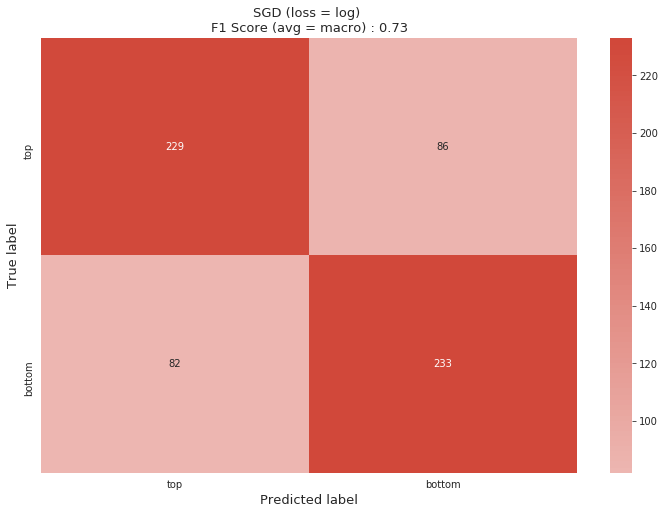

In [0]:
#Confusion Matrix - SGD
#Train test split with stratified sampling. Using non-binarized labels
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = .3, 
                                                    shuffle = True, 
                                                    stratify = y, 
                                                    random_state = 3)
#Fit the training data
sgd_best_model.fit(X_train, y_train)

#Predict the testing data
y_pred = sgd_best_model.predict(X_test)

#Get the confusion matrix and put it into a df
cm = confusion_matrix(y_test, y_pred) 

cm_df = pd.DataFrame(cm,
                     index = ['top','bottom'], 
                     columns = ['top','bottom'])

#Plot the heatmap
plt.figure(figsize=(12, 8))

sns.heatmap(cm_df, 
            center=0, 
            cmap=sns.diverging_palette(220, 15, as_cmap=True), 
            annot=True, 
            fmt='g')

plt.title('SGD (loss = log) \nF1 Score (avg = macro) : {0:.2f}'.format(f1_score(y_test, y_pred, average='macro')), fontsize = 13)
plt.ylabel('True label', fontsize = 13)
plt.xlabel('Predicted label', fontsize = 13)
plt.show()

### Final Prediction on Test set on result_medium_1500_test-set.csv

In [0]:
df_test = pd.read_csv("/content/drive/My Drive/Startus_project/result_medium_1500_test-set.csv")

In [0]:
df_test

,city,country,description,h1,h2,h3,h4,h5,h6,meta,text,title,hash
0,Denver,United States of America,NaN,Unbounded Systems,Unbounded Systems,Unbounded Systems,Unbounded Systems,Unbounded Systems,Unbounded Systems,Unbounded Systems,", our open source tool that makes it easy to d...",Unbounded Systems,6183643cbf8a9e456b78a2f7f53143be1483b39f72c72b...
1,Indianapolis,United States of America,Chapter713Training was founded in 2010. Chapte...,NaN,NaN,NaN,NaN,NaN,NaN,Providing a wide range of discount training an...,"(317)370-5032\n, a well known Certified Parale...","Colorado Bankruptcy Training, LLC",511f65f611fe549910aa2bd10a4078a050baf260527410...
2,Denver,United States of America,"Headquartered in Denver, Colorado, SIGNAL.csk ...",Contact - SIGNAL.csk\nHome - SIGNAL.csk,Align\nBetter Together.\nBuild a brand with la...,Brand Platform & Signals\nBrand Roll-In\nBring...,Contact - SIGNAL.csk\nHome - SIGNAL.csk\nWe lo...,AMANDA DENELLEY\nBRIAN MCMILLEN\nCHERYL FARR\n...,Contact - SIGNAL.csk\nHome - SIGNAL.csk,Home - SIGNAL.csk,*\n.\n//\n01\n02\n03\n1900 Wazee Street\n303.4...,Home - SIGNAL.csk,839f12081bb16f768e30172e6ddfa09df86acb7b0f19f7...
3,Palo Alto,United States of America,DeepMap is solving the HD mapping & localizati...,NaN,NaN,NaN,NaN,NaN,NaN,"Autonomous Driving | United States | DeepMap, ...",".\n10,222,211\n10,267,634\n10,267,635\n10,309,...","Autonomous Driving | United States | DeepMap, ...",e7daa151722ae3e42b61604152a687459d98c57a8a36fb...
4,Chicago,United States of America,We are a collective dedicated to professional ...,NaN,About FWD (For Women & Diversity)\nFWD: A Lett...,"Our community is open to ALL individuals, orga...",Hear From Past FWD Attendees\nSee a few of our...,NaN,NaN,"FWD Collective Summit, Chicago, Women, Diversi...",&\n(773) 999-9733\n.\n41% of managers say they...,FWD Collective,c16622543a791e73a0c14cd3e79720b6a45f5c3a030fe0...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495,Los Angeles,United States of America,"Cubcoats is a venture-backed, startup creating...",Contact Us\nContact Us – Cubcoats\nFAQ\nFAQ – ...,Contact Us\nContact Us – Cubcoats\nCubs In The...,CHARACTER COLLABS\nCompany\nContact Us\nContac...,Contact Us\nContact Us – Cubcoats\nFAQ\nFAQ – ...,Contact Us\nContact Us – Cubcoats\nEmail:\nFAQ...,Contact Us\nContact Us – Cubcoats\nFAQ\nFAQ – ...,The original 2-in-1 hoodie that transform into...,$45.00\n$50.00\n(888) 765-5454\n- Zac and Spen...,Cubcoats® - 2-in-1 hoodies that turns into a p...,660756c9928ed212af6a07c496e05f19b914f017d3141a...
1496,San Francisco,United States of America,Connery Consulting is a boutique HR consulting...,"ALL THINGS PEOPLE\nAUSTIN, TX\nAbout\nAuthenti...",About\nClients\nConnery Consulting - About Us\...,About\nClients\nConnery Consulting - About Us\...,About\nClients\nConnery Consulting - About Us\...,About\nClients\nConnery Consulting - About Us\...,About\nClients\nConnery Consulting - About Us\...,Connery Consulting is a boutique HR consulting...,"""I am reluctant to openly support Nancy with a...",Connery Consulting | Home,2834e8633f248ae62b28f1071b4c2bf926af7e02733357...
1497,Brea,United States of America,E&e Webdesign was founded in 2010. E&e Webdesi...,NaN,Acessorios Paginas Web\nAlarmas Inteligentes P...,Localización\nRedes Sociales\nsobre E&E Webdesign,NaN,NaN,NaN,"diseño de páginas web en PR. website design, p...",). Seguido nos comunicaremos con usted para ma...,E&E Webdesign,a3d6af9e3d0acbc562c6bea0716e4af7bdbc6d9cb5b3a9...
1498,Chicago,United States of America,CORE Industrial Partners is a Private Equity f...,NaN,COMPANY SIZE:\nCORE VALUES:\nCORE'S OPERATING ...,NaN,Adam Miller\nBill Gress\nBill Sullivan\nBob Na...,NaN,NaN,NaN,"150 N. Riverside Plaza, Suite 2050, Chicago, I...",CORE Industrial Partners – Private Equity Firm...,78f5db3659ace48cf7bcb78f8ac10b9ed48bde75234ec3...


In [0]:
#preparing content
df_test.dropna(axis=0)
df_test['des']=[str(m) for m in df_test['description']]
df_test['parsed_content'] =df_test['des'].apply(process_text)


In [0]:

#Putting it all together to make predictions on the unseen text
unseen = df_test['parsed_content'].astype('str') 

#Use the saved models to transform the unseen text with tf-idf and lsa
X_unseen_tfidf = tfidf_vectorizer.transform(unseen) 
X_unseen = lsa.transform(X_unseen_tfidf)

#Fit the models with the best params on the full data
sgd_best_model.fit(X, y)
lr_best_model.fit(X, y)

#Make the prediction on the unseen articles with the fitted best models and put it into a df alongside the correct labels
df_test['pred_sgd'] = [(str(m),str(n)) for m,n in sgd_best_model.predict_proba(X_unseen)]
df_test['pred_lr'] =[(str(i),str(j)) for i,j in lr_best_model.predict_proba(X_unseen)]


df_test = df_test[['description', 'pred_sgd','pred_lr']]

df_test

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished


,description,pred_sgd,pred_lr
0,NaN,"(0.5455971697470337, 0.4544028302529663)","(0.5115822737320151, 0.48841772626798485)"
1,Chapter713Training was founded in 2010. Chapte...,"(0.8665696542363162, 0.13343034576368387)","(0.6790693184574057, 0.3209306815425943)"
2,"Headquartered in Denver, Colorado, SIGNAL.csk ...","(0.2855742439441181, 0.7144257560558819)","(0.3731136310883394, 0.6268863689116606)"
3,DeepMap is solving the HD mapping & localizati...,"(0.0017557755980001089, 0.9982442244019999)","(0.20244877080581325, 0.7975512291941868)"
4,We are a collective dedicated to professional ...,"(0.041478775631596077, 0.9585212243684039)","(0.35862563693602756, 0.6413743630639724)"
...,...,...,...
1495,"Cubcoats is a venture-backed, startup creating...","(0.027262471700526647, 0.9727375282994734)","(0.5326777461331668, 0.46732225386683324)"
1496,Connery Consulting is a boutique HR consulting...,"(0.6793335516992296, 0.32066644830077046)","(0.5803635108992915, 0.4196364891007085)"
1497,E&e Webdesign was founded in 2010. E&e Webdesi...,"(0.9251197573567749, 0.0748802426432251)","(0.7037242050890571, 0.29627579491094297)"
1498,CORE Industrial Partners is a Private Equity f...,"(0.007272861454909796, 0.9927271385450902)","(0.16934417271536728, 0.8306558272846327)"


# **Conclusion** :
Training Accuracy: 84%
Test Accuracy: 77%

The description text is highly similar for both the classes. With bigger data set it might be possible to imrove accuracy.Still there are may techniques like CNN or RNN can be used to improve the score further.
